In [1]:
from Startup import *

finished standard imports
dict_items([('spark.executor.memory', '3g'), ('spark.logConf', 'True'), ('spark.default.parallelism', '10'), ('spark.app.name', 'Weather_PCA'), ('spark.executor.cores', '1'), ('spark.cores.max', '4')])
started SparkContext and SQLContext in 13.09 seconds
loaded weather.parquet in 6.90 seconds
loaded stations.parquet in 0.21 seconds
registered dataframes as tables in 0.20 seconds


In [2]:
%%time
from pyspark.sql.types import *
sc.stop()
sc = SparkContext(appName="CSV2Parquet")
sqlContext = SQLContext(sc)

CPU times: user 24 ms, sys: 4 ms, total: 28 ms
Wall time: 8.07 s


In [3]:
%%time
schemaString = "id year_date element data_value"
schema = StructType([StructField(field_name, StringType(), True) for field_name in schemaString.split()])
allYears = np.arange(1763,2021)
for yr in allYears:
    fn = "s3://noaa-ghcn-pds/csv/" + str(yr) + ".csv"
    dt = sc.textFile(fn).map(lambda l: l.split(",")).map(lambda p: ([x.strip() for x in p[0:4]]))
    schemaDT = sqlContext.createDataFrame(dt, schema)
    if yr == allYears[0]:
        df = schemaDT
    else:
        df = df.union(schemaDT)

CPU times: user 2.24 s, sys: 152 ms, total: 2.39 s
Wall time: 9.08 s


In [4]:
# %%time
# df.write.parquet("GHCND.parquet")

CPU times: user 404 ms, sys: 48 ms, total: 452 ms
Wall time: 46min 19s


In [8]:
%%time
df.write.parquet("s3://philipp-ghcnd/GHCND.parquet")

CPU times: user 656 ms, sys: 60 ms, total: 716 ms
Wall time: 1h 36min 38s


In [9]:
# df.coalesce(1).write.parquet("s3://philipp-ghcnd/GHCNDall.parquet")

In [5]:
%%time
qry = """
SELECT SUBSTRING(year_date, 1, 4) AS year, 
       COUNT(element) AS count
FROM parquet.`GHCND.parquet`
WHERE SUBSTRING(year_date, 5, 8)<>'0229'
GROUP BY SUBSTRING(year_date, 1, 4)
ORDER BY SUBSTRING(year_date, 1, 4) ASC"""
results = sqlContext.sql(qry)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 1.24 s


In [6]:
%%time
results.show()

+----+-----+
|year|count|
+----+-----+
|1763|  730|
|1764|  730|
|1765|  730|
|1766|  730|
|1767|  730|
|1768|  730|
|1769|  730|
|1770|  730|
|1771|  730|
|1772|  730|
|1773|  730|
|1774|  730|
|1775| 1460|
|1776| 1460|
|1777| 1460|
|1778| 1460|
|1779| 1460|
|1780| 1460|
|1781| 1825|
|1782| 1825|
+----+-----+
only showing top 20 rows

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 50.3 s


CPU times: user 236 ms, sys: 4 ms, total: 240 ms
Wall time: 1min 21s


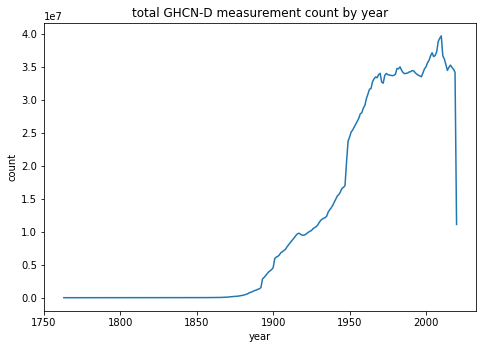

In [7]:
%%time
allyears = results.select('year').collect()
allcounts = results.select('count').collect()
from matplotlib import pyplot as plt
%matplotlib inline
fig1 = plt.figure()
ax1 = fig1.add_axes([0,0,1,1])
ax1.plot(allyears, allcounts)
ax1.set_title('total GHCN-D measurement count by year')
ax1.set_ylabel('count')
ax1.set_xlabel('year')